# Setup

Please note we had to simplify the notebook and the model, hyperparameter and training complexity to achieve results. This is because we twice ran into Colab's limits and even had to open an additional Google account to get the results that follow.

In [1]:
%%capture
!pip install git+https://github.com/AndreCNF/ccai-ss23-ai-monitoring-tutorial.git@ec25e47d0c29ab34c9afbf5b5c2d2de6b80db2b8
!pip install gdown

In [97]:
# Model training
import torch, timm
import lightning as L
import pandas as pd
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from coal_emissions_monitoring.model import CoalEmissionsModel, SmallCNN
from torch import nn
import os, itertools, random
from coal_emissions_monitoring.dataset import CoalEmissionsDataModule, CoalEmissionsDataset

# set the random seed for reproducibility
GLOBAL_RANDOM_SEED = 42
L.seed_everything(GLOBAL_RANDOM_SEED)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

# Data Preprocessing

Here we're going to decompress our satellite images, configure a dataset and explore what's in the data.

In [6]:
# Data download and preprocessing
!gdown --folder https://drive.google.com/drive/folders/1TrgvYM7SW3Z9KQaohlPsCqehsZgWK8MA
!mkdir images
!tar -C images -xf data/images/visual_images.tar.gz
!rm -rf data/images/visual_images.tar.gz
images_path = "/content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual"

Retrieving folder list
Processing file 1CGmfnNdIpukYobJaknbOBd1PEXdmC1h2 all_urls_dataset.csv
Processing file 193gcBwi2jUNNpBRk1riKUM6ntHu1Q9Fr final_dataset.csv
Processing file 18-3u46Ve4_Ioofd7YcAHErBDuPAoLw3a image_metadata.csv
Retrieving folder 1n123Hp_LVmMUBDvDfC3nftFTUfMidGaO images
Processing file 1JBLJoYlMgHI87GEvcBMZyjmoq_RYylyh .DS_Store
Processing file 1M8M_7prrLPcuNR-sWxDR8EpLuyfKFj41 all_bands_images.tar.gz
Processing file 1h_GsgpDpyrZZlyU_fvLpXokzjQh81CAC visual_images.tar.gz
Processing file 1ZP224rP-9jNMqkuainpwE2GjwT23UinJ labeled_geospatial_data.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1CGmfnNdIpukYobJaknbOBd1PEXdmC1h2
To: /content/data/all_urls_dataset.csv
100% 15.9M/15.9M [00:00<00:00, 75.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=193gcBwi2jUNNpBRk1riKUM6ntHu1Q9Fr
To: /content/data/final_dataset.csv
100% 3.28M/3.28M [00:00<00:00, 62.2MB/

In [7]:
# Data setup
batch_size = 64
crop_size = 64
data = CoalEmissionsDataModule(final_dataset_path="/content/data/final_dataset.csv",
                               batch_size=batch_size,
                               crop_size=crop_size,
                               num_workers=os.cpu_count(),
                               predownload_images=True,
                               download_missing_images=False,
                               images_dir=images_path)
data.setup("fit")
data.setup("test")

# Task 1: implement MySmallCNN
Implement a variation of SmallCNN, class `MySmallCNN`, which generalizes the above-mentioned structure. You should create a model that implements a number of blocks (`num_blocks`), each having the following structure:
<ul>
  <li> A convolutional layer with output shape <code>conv_output_channels</code> and tunable kernel and padding (here a <a href="https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md">visual explanation</a> of their meaning). The convolution layer should be activated using ReLU.
  </li>
  <li> A max-pooling layer, again with tunable kernel size. For the final block, use an average pooling with an output size of 1 instead (for an explanation of the different pooling strategies see <a href="https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/">here</a>).
  </li>
</ul>

Finally, add one last fully-connected output layer. You do not need to apply an output function to the final layer, as the loss function used by the `CoalEmissionsModel` already includes a sigmoid transformation before computing the binary cross-entropy loss (`BCEWithLogitsLoss`).
 ***A few notes***:
You don't have to implement your model in `pytorch`, any DL library of your choice works. However, you might encounter some compatibility issues when training with `lightning`.
You also want to make sure that the dimension of the layers are compatible with each other and that the output of the algorithm can be adapted for classification problems for an arbitrary number of classes `num_classes`. Finally, while testing your implementation, you may want to turn on the parameter `fast_dev_run` in your trainer configuration, so that you will only test its functioning for a few loops.


## Implementation

If we understand correctly, the number of blocks that we need to crete depend on `num_blocks`. During consultation with Chiara, she mentioned we should not use a `for` to do this dynamically. Unfortunately, after doing some research we couldn't find any built-in or alternative way of implementing this, so we did go with a for loop. Additionally, we implemented the class inheriting from `nn.Sequential` to simplify things, not from the original `SmallCNN`.

In [71]:
# Define architecture with custom block_number

class MySmallCNN(nn.Sequential):

    def __init__(self,
                 num_input_channels=3,
                 num_blocks=1,
                 num_classes=1,
                 conv_output_channels=32,
                 conv_kernel_size=3,
                 conv_padding=1,
                 pool_kernel_size=2):
        super(MySmallCNN, self).__init__()
        # Implement user defined blocks with requested architecthure
        blocks = []
        for _ in range(num_blocks):
            # Add convolution layer to block
            blocks.append(nn.Conv2d(num_input_channels,
                                    conv_output_channels,
                                    kernel_size=conv_kernel_size,
                                    padding=conv_padding))
            # Add ReLU activation to block
            blocks.append(nn.ReLU())
            # Add max pooling to block
            blocks.append(nn.MaxPool2d(kernel_size=pool_kernel_size))
            num_input_channels = conv_output_channels
        # Final block with adaptive average pooling to ensure layer compatibility and size 1 output
        blocks.append(nn.AdaptiveAvgPool2d(output_size=1))
        # Make machine-readable
        blocks.append(nn.Flatten())
        # Output layer
        blocks.append(nn.Linear(conv_output_channels, num_classes))
        # Put whole architecture together
        self.extend(blocks)

    def forward(self, x):
        return super().forward(x)

In [72]:
# Instantiate a model with two blocks
model = MySmallCNN(num_input_channels=3,
                   num_blocks=2,
                   conv_output_channels=32)

# Instantiate CoalEmissionsModel() with our model
coal_model = CoalEmissionsModel(model=model,
                                learning_rate=1e-3,
                                pos_weight=data.pos_weight)

In [84]:
# Declare trainer configuration
trainer_configuration = {'max_epochs': 5,
                         'callbacks': [EarlyStopping(monitor="val_loss", mode="min", patience=10, min_delta=0.00),
                                       ModelCheckpoint(dirpath="/content/my_models/",
                                       filename="{val_loss:.3f}-{val_balanced_accuracy:.1%}-{epoch}-full_data",
                                       monitor="val_balanced_accuracy",
                                       mode="max")],
                         'limit_train_batches': round(1 * len(data.train_dataset.gdf) / batch_size),
                         'limit_val_batches': round(1 * len(data.val_dataset.gdf) / batch_size),
                         'reload_dataloaders_every_n_epochs': 1,
                         'precision': '16-mixed',
                         'accelerator': 'gpu',
                         'logger': True,
                         'log_every_n_steps': 1,
                         #'fast_dev_run': True
                         }

In [70]:
# Instatiate trainer and train
trainer = Trainer(**trainer_configuration)
trainer.fit(coal_model, data)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type              | Params
--------------------------------------------
0 | model | MySmallCNN        | 10.2 K
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
10.2 K    Trainabl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [73]:
# Test
trainer.test(model=coal_model,
             dataloaders=data,
             ckpt_path="best",
             verbose=False)

INFO: Restoring states from the checkpoint path at /content/my_models/val_loss=0.176-val_balanced_accuracy=57.2%-epoch=4-full_data.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/my_models/val_loss=0.176-val_balanced_accuracy=57.2%-epoch=4-full_data.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/my_models/val_loss=0.176-val_balanced_accuracy=57.2%-epoch=4-full_data.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/my_models/val_loss=0.176-val_balanced_accuracy=57.2%-epoch=4-full_data.ckpt
2023-10-18 19:19:36.771 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200830_0_L2A_TCI_8.998639999

Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 19:19:37.390 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200810_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:19:37.467 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20201225_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:19:37.493 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200404_0_L2A_TCI_8.99863999999921

[{'test_loss': 0.21244025230407715,
  'test_accuracy': 0.5565077662467957,
  'test_balanced_accuracy': 0.6210671069169422,
  'test_recall': 0.5173717141151428,
  'test_precision': 0.8851686716079712}]

In [89]:
mySmallCNN_results = [{'test_loss': 0.21244025230407715,
  'test_accuracy': 0.5565077662467957,
  'test_balanced_accuracy': 0.6210671069169422,
  'test_recall': 0.5173717141151428,
  'test_precision': 0.8851686716079712}]

## Task 2: fine tune your model hyperparameters with MyTuner

In the second task, you will have to implement a hyperparameter tuner from scratch and use it to tune the hyperparameters for `MySmallCNN`. The hyperarameter tuner should:
<ul>
<li> be implemented from scratch without the help of DL libraries (you may resort to default libraries such as <code>numpy</code>, <code>collections</code> or <code>itertools</code>)
<li> contain two search methods, <code>grid_search</code> and <code>random_search</code>, which both make use of the private method <code>_compare_models</code> to compare the result of the model with a new hyperparameter selection and the current best model based on the defined metric.
<li> The methods should return the current best hyperparameter selection and current best metrics score after search. Pre-existing best hyperparameter selection and score should be overwritten if necessary (this is not best-practice in hyperparameter search, but will simplify our class).

In [79]:
# This tuner optimizes for loss

class MyTuner:

    def __init__(self,
                 model_class,
                 hp_trainer_config,
                 max_iter=10):
        self.model_class = model_class
        self.hp_trainer_config = hp_trainer_config
        self.max_iter = max_iter
        self.best_hyperparameter_combination = None
        self.best_loss = float('inf')

    def _compare_models(self,
                        data,
                        hyperparameters):
        # Initialize with hyperparameters
        model = self.model_class(**hyperparameters)
        # Instantiate as CoalEmissionsModel()
        coal_model = CoalEmissionsModel(model=model, learning_rate=1e-3, pos_weight=data.pos_weight)
        # Instantiate with configuration
        trainer = Trainer(**self.hp_trainer_config)
        # Train the model
        trainer.fit(coal_model, data)
        # Evaluate
        results = trainer.test(model=coal_model, dataloaders=data, ckpt_path="best", verbose=False)
        # Retrieve test loss from results dictionaries where available
        loss = None
        for result in results:
            if 'test_loss' in result:
                loss = result['test_loss']
                break
        if loss is None:
            raise KeyError("Test loss unavailable!")
        return hyperparameters, loss

    def grid_search(self, data, hyperparameter_space):
        # Hyperparameter cominations here are exhaustive
        combinations = list(itertools.product(*hyperparameter_space.values()))
        # Test all combinations and return combination with lower loss
        for combination in combinations:
            hyperparameters = dict(zip(hyperparameter_space.keys(), combination))
            current_hyperparameter_combination, current_loss = self._compare_models(data, hyperparameters)
            if current_loss < self.best_loss:
              self.best_loss = current_loss
              self.best_hyperparameter_combination = current_hyperparameter_combination
        return self.best_hyperparameter_combination, self.best_loss

    def random_search(self, data, hyperparameter_space):
        for _ in range(self.max_iter):
          # Explore hyperparameter space randomly
          hyperparameters = {k: random.choice(v) for k, v in hyperparameter_space.items()}
          current_hyperparameter_combination, current_loss = self._compare_models(data, hyperparameters)
          if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_hyperparameter_combination = current_hyperparameter_combination
        return self.best_hyperparameter_combination, self.best_loss

In [80]:
hp_trainer_config = {'max_epochs': 5,
                     'callbacks': [EarlyStopping(monitor="loss",
                                                 mode="min",
                                                 patience=10,
                                                 min_delta=0.00)],
                     'limit_train_batches': round(1 * len(data.train_dataset.gdf) / batch_size),
                     'limit_val_batches': round(1 * len(data.val_dataset.gdf) / batch_size),
                     'reload_dataloaders_every_n_epochs': 1,
                     'precision': '16-mixed',
                     'accelerator': 'gpu',
                     'logger': True,
                     'log_every_n_steps': 1}

In [117]:
# We had to restrict the parameter space to see the training process finish within our lifetimes.
hyperparameter_space = {"num_blocks" : [1],
                        "pool_kernel_size": [2],
                        "conv_output_channels": [2**4]}
# Instantiate tuner
tuner = MyTuner(MySmallCNN, hp_trainer_config, max_iter=10)
# Run tuner with both strategies
best_grid_hyperparameters, best_grid_loss = tuner.grid_search(data, hyperparameter_space)
best_random_hyperparameters, best_random_loss = tuner.random_search(data, hyperparameter_space)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
2023-10-18 20:22:24.152 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200110_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be sm

Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:22:24.458 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200805_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:22:24.695 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200807_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:22:24.941 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200328_0_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
2023-10-18 20:22:58.014 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200427_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be sm

Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:22:58.606 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200810_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:22:59.348 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200328_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:22:59.484 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200110_0_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
2023-10-18 20:23:32.687 | WARNING  | coal_emissions_monitoring.dataset:__iter__:122 - Could not load local image at nan. Original error: expected str, bytes or os.PathLike object, not float
2023-10-18 20:23:32.754 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/

Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:23:33.296 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20201225_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:23:33.582 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200110_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:23:33.727 | WARNING  | coal_emissions_monitoring.dataset:__iter__:122 - Could not load local image at nan. Original error: expected str, bytes or os.PathLike object, not float
2023-10-18 20:23:34.127 | WARNING  | coal_emissions_monitoring.datas

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
2023-10-18 20:24:09.166 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200328_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be sm

Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:24:09.672 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200805_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:24:09.973 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200830_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:24:10.809 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200115_0_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=46.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=46.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=46.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=46.ckpt
2023-10-18 20:24:41.565 | WARNING  | coal_emissions_monitoring.dataset:__iter__:122 - Could not load local image at nan. Original error: expected str, bytes or os.PathLike object, not float


Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:24:42.097 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20201103_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:24:42.116 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200807_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:24:42.401 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200404_0_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
2023-10-18 20:25:16.310 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200110_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be sm

Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:25:18.100 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200115_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:25:18.250 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200810_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:25:18.404 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200911_0_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=48.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=48.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=48.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=48.ckpt
2023-10-18 20:25:46.459 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200328_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be sm

Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:25:47.015 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200830_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:25:47.406 | WARNING  | coal_emissions_monitoring.dataset:__iter__:122 - Could not load local image at nan. Original error: expected str, bytes or os.PathLike object, not float
2023-10-18 20:25:47.752 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200417_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:25:47.847 | WARNING  | coal_emissions_monitoring.datas

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
2023-10-18 20:26:24.325 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200417_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be sm

Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:26:24.952 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200115_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:26:25.325 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20201103_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:26:25.444 | WARNING  | coal_emissions_monitoring.dataset:__iter__:122 - Could not load local image at nan. Original error: expected str, bytes or os.PathLike object, not float
2023-10-18 20:26:25.521 | WARNING  | coal_emissions_monitoring.datas

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
2023-10-18 20:27:05.344 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200417_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be sm

Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:27:05.863 | WARNING  | coal_emissions_monitoring.dataset:__iter__:122 - Could not load local image at nan. Original error: expected str, bytes or os.PathLike object, not float
2023-10-18 20:27:05.909 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200110_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:27:06.016 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200830_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:27:06.214 | WARNING  | coal_emissions_monitoring.datas

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
2023-10-18 20:27:44.756 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20201103_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be sm

Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:27:45.328 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200805_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:27:46.304 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200810_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:27:47.281 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200911_0_L2A_TCI_8.99863999999921

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:28:30.400 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200404_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:28:30.603 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200417_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:28:30.945 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200911_0_L2A_TCI_8.99863999999921

In [118]:
print(f"Best selection with grid search: {best_grid_hyperparameters}, losse: {best_grid_loss: .2f}")
print(f"Best selection with random search: {best_random_hyperparameters}, loss: {best_random_loss: .2f}")

Best selection with grid search: {'num_blocks': 1, 'pool_kernel_size': 2, 'conv_output_channels': 16}, losse:  0.38
Best selection with random search: {'num_blocks': 1, 'pool_kernel_size': 2, 'conv_output_channels': 16}, loss:  0.23


## Train and test a model with the grid search parameters

In [119]:
best_coal_model = CoalEmissionsModel(model=MySmallCNN(**best_grid_hyperparameters),
                                    learning_rate=1e-3,
                                    pos_weight=data.pos_weight)
best_trainer = Trainer(**hp_trainer_config)
best_trainer.fit(best_coal_model, data)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_z

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [120]:
best_trainer.test(model=best_coal_model,
                  dataloaders=data,
                  ckpt_path="best",
                  verbose=False)

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 20:33:12.946 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200110_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:33:13.238 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20200807_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 20:33:13.484 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200805_0_L2A_TCI_8.99863999999921

[{'test_loss': 0.27693304419517517,
  'test_accuracy': 0.38564541935920715,
  'test_balanced_accuracy': 0.414084822965202,
  'test_recall': 0.3652646243572235,
  'test_precision': 0.7425063252449036}]

In [123]:
tuned_results = [{'test_loss': 0.27693304419517517,
  'test_accuracy': 0.38564541935920715,
  'test_balanced_accuracy': 0.414084822965202,
  'test_recall': 0.3652646243572235,
  'test_precision': 0.7425063252449036}]

## Task 3: load and train a pre-trained model

There are many more experiments that can be done to try to improve emissions estimates from satellite images. For example, one could load different pre-trained models and investigate how different CNN architectures perform on the same problem.
<ul>
  <li>Load and train a pre-trained model for classification problem using a different CNN architecture with another set of pre-trained weights. Depending on the model you choose, you might have to modify the architecture slights.</li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>


## Choosing a  pretrained model
Since we are using PyTorch, we'll test a model from `torchvision`, let's see what is available:





In [61]:
from torchvision import models
len(models.list_models())

121

There are 121 models to choose from! But we know nothing about their architecture or performance. The former aside, here's a [graph](https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/) comparing their performance:

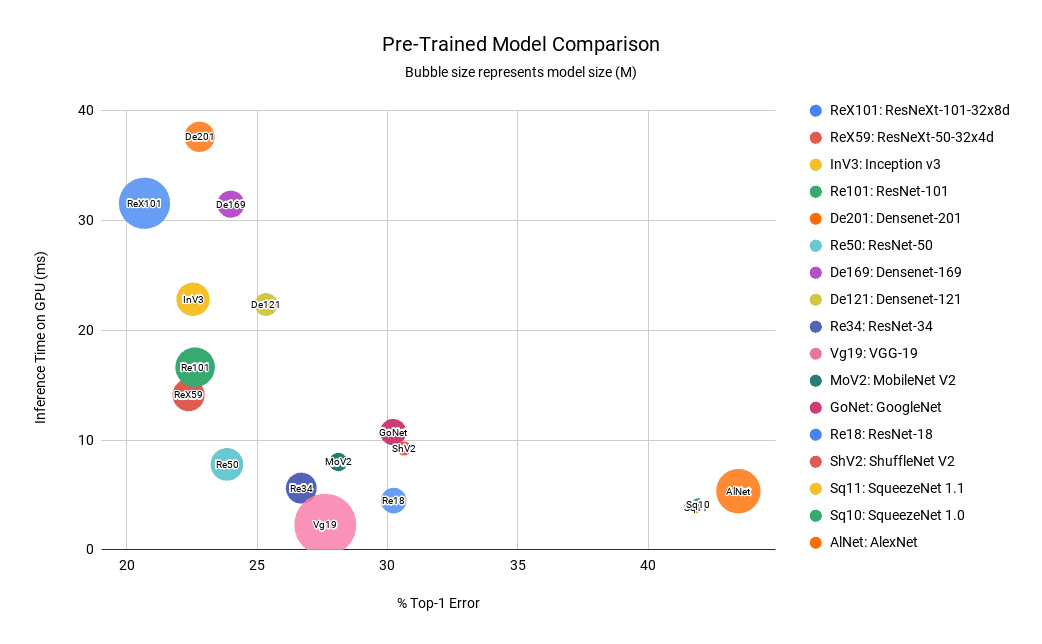

The horizontal axis captures top-1 error (lower is better), the vertical one the inference time on GPU in milliseconds (lower is better) and the bubble size represents the model size (lower is better). While it would be nice to use the best performing, fastest and smallest model, here we will concentrate in a decently performing, fast and small model due tyo hardware limitations. [This table](https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights) is also useful. We see that ShuffleNet is the model with the least parameters and requries the least compute, so it seems fitting.

In [85]:
# Instantiate pretrained model
shufflenet = models.shufflenet_v2_x0_5(weights='IMAGENET1K_V1')
# Reconfifure the model shape to fit our task
number_of_classes = 1
shufflenet.fc = nn.Linear(shufflenet.fc.in_features, number_of_classes)

In [86]:
pretrained_model = CoalEmissionsModel(model=shufflenet,
                                          learning_rate=1e-3,
                                          pos_weight=data.pos_weight,)

In [87]:
pretrained_trainer = Trainer(**trainer_configuration)
pretrained_trainer.fit(pretrained_model, data)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:630: Checkpoint directory /content/my_models exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type              | Params
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

2023-10-18 19:35:37.832 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:35:37.886 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:35:37.947 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921

Training: |          | 0/? [00:00<?, ?it/s]

2023-10-18 19:35:38.734 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210213_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:35:38.748 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180717_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:35:57.272 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 19:35:57.480 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190118_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:35:57.650 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:35:57.777 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190806_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 19:36:20.798 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:36:20.852 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20180513_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:36:20.862 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190922_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 19:36:41.552 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180902_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:36:41.625 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:36:41.717 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20181211_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 19:37:04.009 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190614_1_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:37:04.066 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20210305_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:37:04.411 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20181211_0_L2A_TCI_8.99863999999921

Validation: |          | 0/? [00:00<?, ?it/s]

2023-10-18 19:37:25.451 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180505_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:37:25.532 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2B_32UND_20190518_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:37:25.709 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20180806_0_L2A_TCI_8.99863999999921

In [88]:
pretrained_trainer.test(model=pretrained_model,
                        dataloaders=data,
                        ckpt_path="best",
                        verbose=False)

INFO: Restoring states from the checkpoint path at /content/my_models/val_loss=0.341-val_balanced_accuracy=59.1%-epoch=1-full_data.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/my_models/val_loss=0.341-val_balanced_accuracy=59.1%-epoch=1-full_data.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/my_models/val_loss=0.341-val_balanced_accuracy=59.1%-epoch=1-full_data.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/my_models/val_loss=0.341-val_balanced_accuracy=59.1%-epoch=1-full_data.ckpt
2023-10-18 19:38:45.433 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20201103_0_L2A_TCI_8.998639999

Testing: |          | 0/? [00:00<?, ?it/s]

2023-10-18 19:38:46.117 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200427_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:38:46.413 | WARNING  | coal_emissions_monitoring.dataset:__iter__:122 - Could not load local image at nan. Original error: expected str, bytes or os.PathLike object, not float
2023-10-18 19:38:46.450 | WARNING  | coal_emissions_monitoring.dataset:__iter__:140 - Could not transform image at /content/images/Users/adminuser/GitHub/ccai-ss23-ai-monitoring-tutorial/data/google/images/visual/S2A_32UND_20200328_0_L2A_TCI_8.99863999999921_52.38263996813044_64.npy. Original error: Crop size must be smaller than input size. Got (64, 25) and (64, 64).
2023-10-18 19:38:46.930 | WARNING  | coal_emissions_monitoring.datas

[{'test_loss': 0.19546960294246674,
  'test_accuracy': 0.8810926675796509,
  'test_balanced_accuracy': 0.7773651789987963,
  'test_recall': 0.9490727782249451,
  'test_precision': 0.9071743488311768}]

In [92]:
pretrained_results = [{'test_loss': 0.19546960294246674,
  'test_accuracy': 0.8810926675796509,
  'test_balanced_accuracy': 0.7773651789987963,
  'test_recall': 0.9490727782249451,
  'test_precision': 0.9071743488311768}]

In [112]:
SmallCNN_results = [{'test_loss': 0.132,
  'test_accuracy': 0.7515,
  'test_balanced_accuracy': 0.8376,
  'test_recall': 0.6965,
  'test_precision': 0.9928}]

# Task  4: results and discussion


In [124]:
results = [SmallCNN_results, mySmallCNN_results, tuner_results, pretrained_results]
flat_data = [item for sublist in results for item in sublist]
columns = ['SmallCNN', 'MySmallCNN', 'Tuned', 'Pretrained']
table = pd.DataFrame(flat_data).transpose()
table.columns = columns
table

,SmallCNN,MySmallCNN,Tuned,Pretrained
test_loss,0.1320,0.212440,0.395560,0.195470
test_accuracy,0.7515,0.556508,0.780396,0.881093
test_balanced_accuracy,0.8376,0.621067,0.507444,0.777365
test_recall,0.6965,0.517372,0.954015,0.949073
test_precision,0.9928,0.885169,0.808078,0.907174


# MySmallCNN and Tuned
This architecture offered a customizable number of blocks. It is unclear why this particular configuration was chosen and in order to see what more blocks do to performance, we would need to compare the results of the grid search. However, it was interesting to implement the search and random algorithms from scratch. They were not as complicated as they seemed. Implementing them and running tests was also very useful in understanding the architecture design process, that although has a more deterministic part -layers should follow a logical order and be compatible- surely has a more exploratory side that is very computationaly heavy to explore.

In the case of our particular results, we noticed that some metrics are contradictory between the standard model and the tuned version. This is of course due to the restrictions we imposed on the hyperparameter space, but nevertheless is also a reflection of the random initialization of these models. This plays a more important role in compute-starved environments like the one we used to explore the notebook.

# Pretrained

The pretrained model's performance was the best in almost every metric -among the ones we implemented- and very computationally cheap for an out-of-the-box solution. While this is interesting in itself, the most important conclusion is perhaps the realization that there is a world of educationally -like the ones we sifted through here- and commercially available models out there. The compute and technical knowledge it takes for these models to be devised and trained is simply not available to most of us. It was very itneresting to see that much can be achieved with a few lines of code.

# Other conclusions and comments

It would be very nice to have a session or workshop to teach us how to use the GPU farm at Hertie. This assignment showed that the free tools available are not enough for proper experimentation, not even Colab.